# Mercedes-Benz Greener Manufacturing

from: https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55

In [1]:
import numpy as np #linear algebra
import pandas as pd # data processing 
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal= sns.color_palette()

In [2]:
# Training Set
train =pd.read_csv('./train.csv')
print('Size of training set: ', train.shape )

Size of training set:  (4209, 378)


In [3]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


ID는 행번호가 아니다. 이건 뭔가 중요하다. 
두번째 컬럼 숫자 타겟을 일으킬 수있는 컬럼이다. id는...



min(최솟값): 72.11
max(최댓값):265.32
mean(평균):100.66931812782134
std(표준편차):12.6778749695168


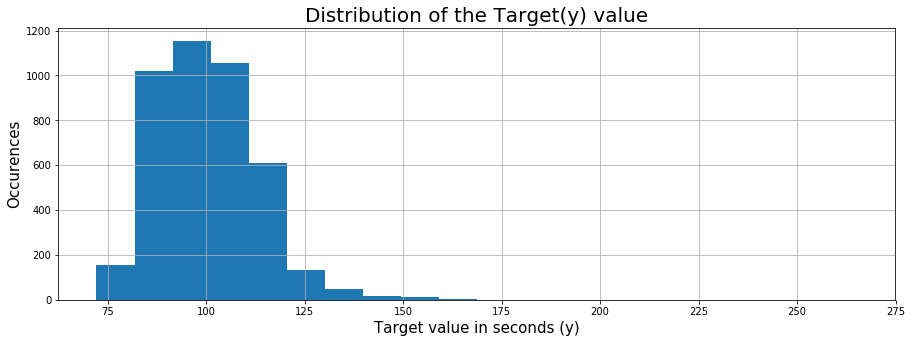

In [4]:

y_train = train['y'].values

plt.figure(figsize=(15,5))

plt.hist(y_train, bins=20)

plt.xlabel('Target value in seconds (y)', fontsize=15)

plt.ylabel('Occurences', fontsize=15)

plt.grid() #격자무늬
plt.title('Distribution of the Target(y) value', fontsize=20)


print('\n\nmin(최솟값): {}\nmax(최댓값):{}\nmean(평균):{}\nstd(표준편차):{}'.format(min(y_train), 
                                                                   max(y_train), 
                                                                   y_train.mean(), 
                                                                   y_train.std()))

대부분의 트레인 데이터셋에서 y값이 거의100 근처이다.

180보다 큰수들은 180으로 맞춘다.

ID는 행번호 같은 ID가 아님을 알 수있다. 

여기서 ID는 트레인데이터와 테스트 데이터셋은 

동일한 데이터셋에서 랜덤으로 샘플링된 것이다.

target값이 시간에 지남에따라 어떻게 변하는지를 봐야한다.

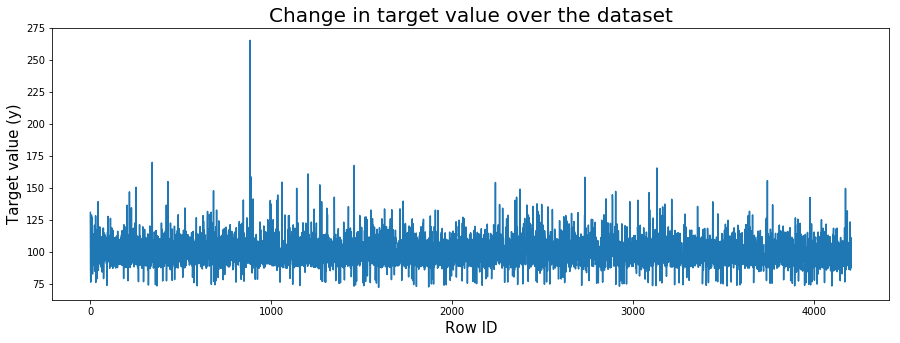

In [5]:
plt.figure(figsize=(15,5))
plt.plot(y_train)
plt.xlabel('Row ID', fontsize=15)
plt.ylabel('Target value (y)', fontsize=15)
plt.title('Change in target value over the dataset', fontsize=20)
plt.show()

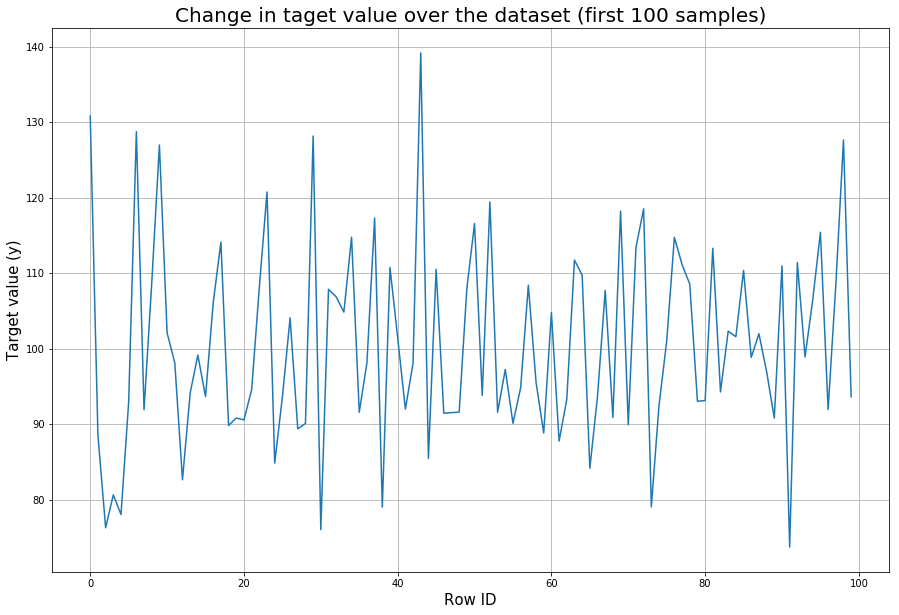

In [6]:
plt.figure(figsize=(15,10))
plt.plot(y_train[:100])
plt.xlabel('Row ID', fontsize=15)
plt.ylabel('Target value (y)', fontsize=15)
plt.title('Change in taget value over the dataset (first 100 samples)',
          fontsize=20)

plt.grid()
plt.show()

그냥 보기에는 어느것도 부자연스럽게 수상해보이지 않는다.

랜덤 sort..

자세히 보면.. 수상해보인다.. feature들을 탐색해보자.

# Featrue Analysis

In [7]:
cols=[c for c in train.columns if 'X' in c] #컬럼 train.columns중에서 XOO으로 되어있는 컬럼만을 고른다.
print('[Number of "X" features] {}'.format(len(cols)))

print('[Feature types]\n{}'.format(train[cols].dtypes.value_counts()))

[Number of "X" features] 376
[Feature types]
int64     368
object      8
dtype: int64


int64 타입인 컬럼개수는 368개, object타입(String)은 8개

In [13]:
counts=[ [],[],[]] 
#0번째: 구성 원소(중복배제)가 1개밖에 없는 컬럼.
#1번째: 구성 원소(중복배제)가 2개밖에 없으면서, 타입이 int64인 컬럼

for c in cols: # X(숫자) 로된 컬럼들 중에서....
    typ=train[c].dtype # 종류
    uniq= len(np.unique(train[c])) #train[c]을 구성하는값(단일값)의 개수를 구한다.

    if uniq==1: #값이 1개밖에 없는 경우
        counts[0].append(c)
    
    elif uniq==2 and typ==np.int64: #값이 2개밖에 없고, 타입은 int64인경우
        counts[1].append(c)
    
    else:
        counts[2].append(c)
        
        
print('Constant features: {}\nBinary features: {}\nCategorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features: ', counts[0])
print('len(Constant features): {}\n'.format(len(counts[0])) )

print('Categorical features: ', counts[2])
print('len(Categorical features): {}'.format(len(counts[2])) )

Constant features: 12
Binary features: 356
Categorical features: 8

Constant features:  ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
len(Constant features): 12

Categorical features:  ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
len(Categorical features): 8


12개 feature들은 딱 한개의 값만을 갖는다.

한 개값을 갖는 feature은 지도학습에서 불필요하다. 그래서 drop 해야한다.

나머지 데이터셋은 대부분이 binary features이다.

일부 8개는 카테고리형 features이다.

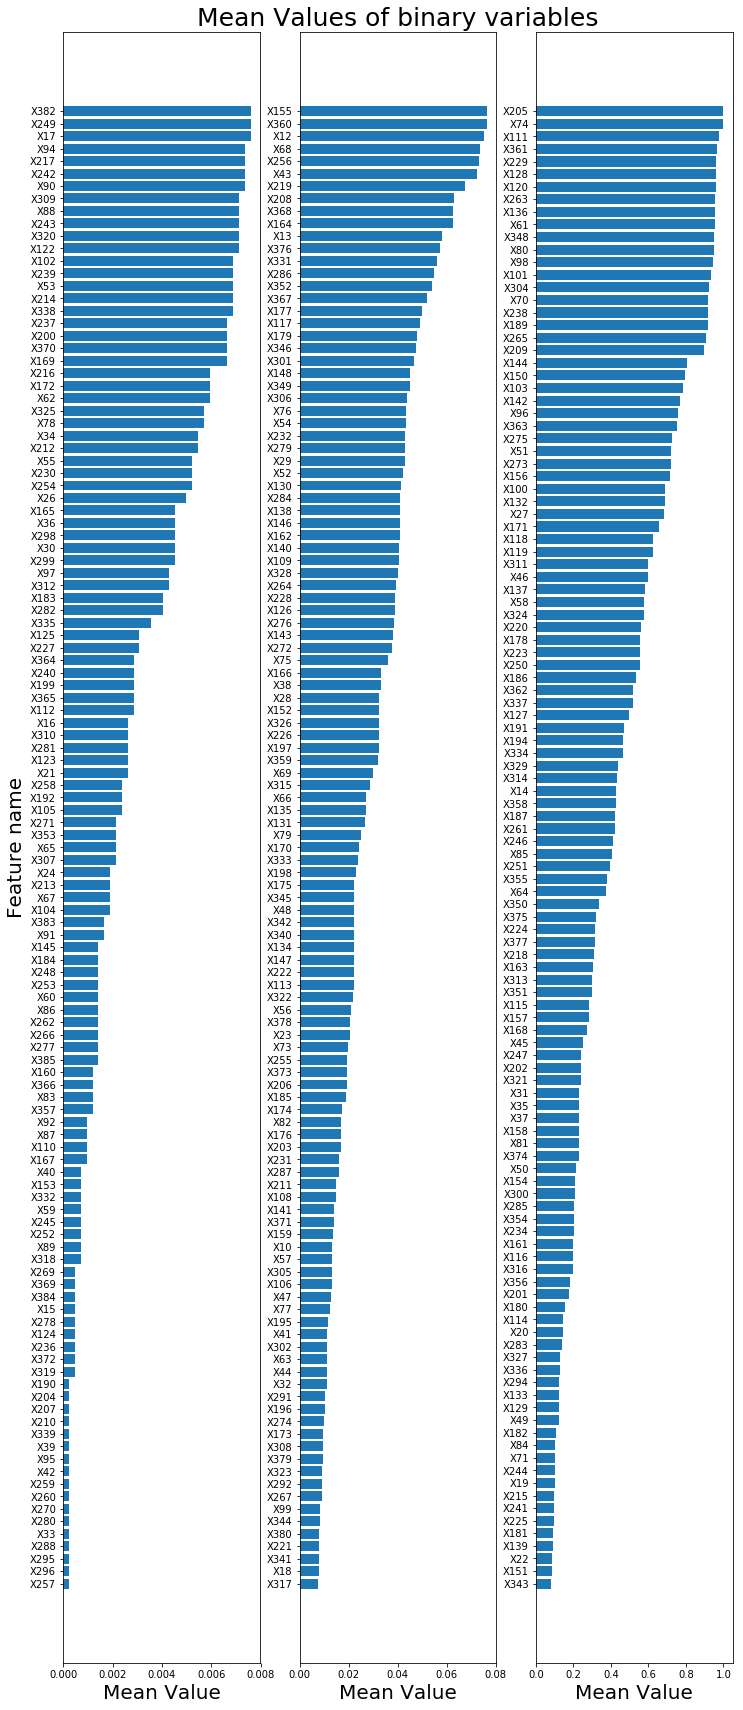

In [16]:
binary_means=[np.mean(train[c]) for c in counts[1]]

binary_names=np.array(counts[1])[np.argsort(binary_means)]

binary_means= np.sort(binary_means)

fig, ax = plt.subplots(1,3,figsize=(12,30))
ax[0].set_ylabel('Feature name', fontsize=20)
ax[1].set_title('Mean Values of binary variables', fontsize=25)

for i in range(3):
    names, means =binary_names[i*119: (i+1)*119], binary_means[i*119:(i+1)*119]
    
    ax[i].barh(range(len(means)), means, color=pal[0])
    
    ax[i].set_xlabel('Mean Value', fontsize=20)
    ax[i].set_yticks(range(len(means)))
    ax[i].set_yticklabels(names, rotation='horizontal')

plt.show()

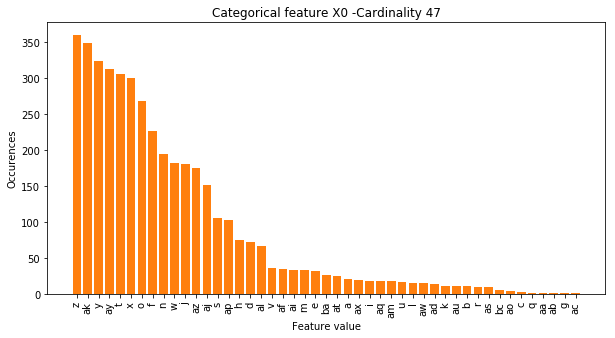

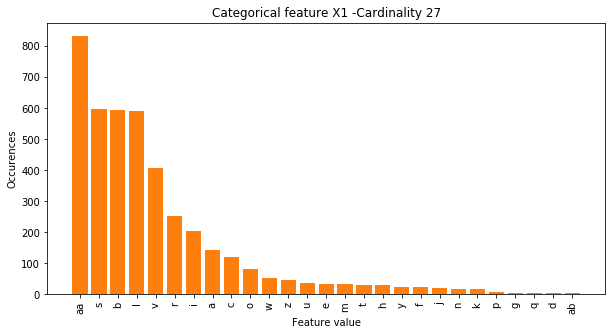

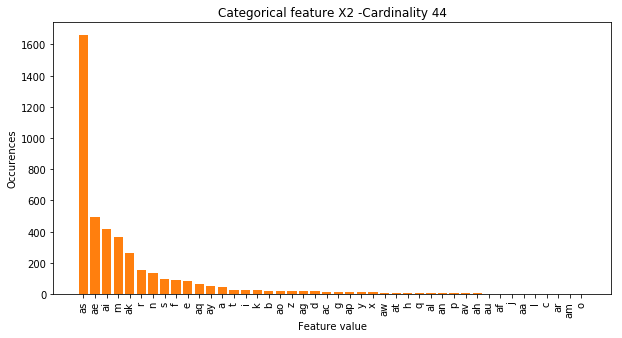

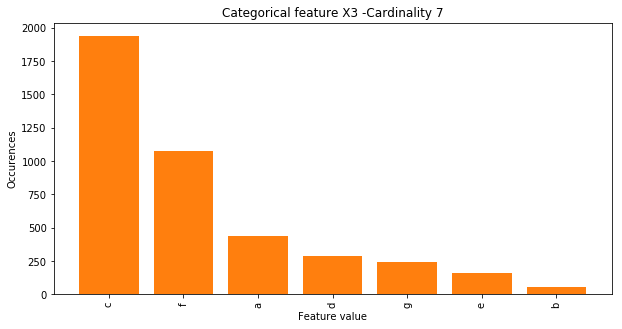

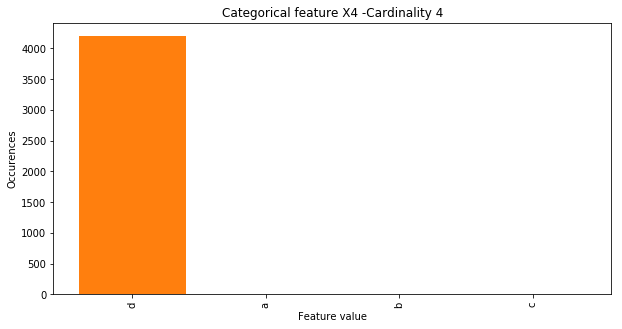

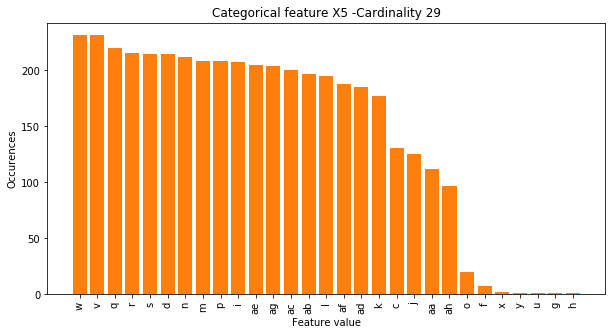

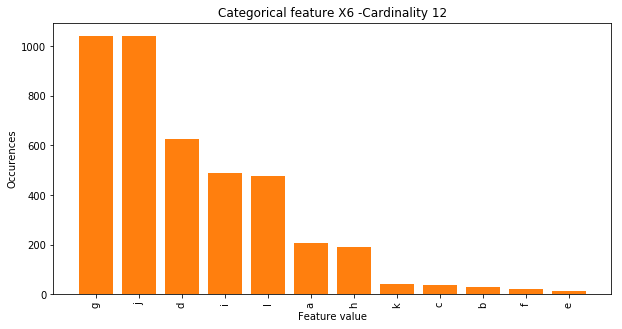

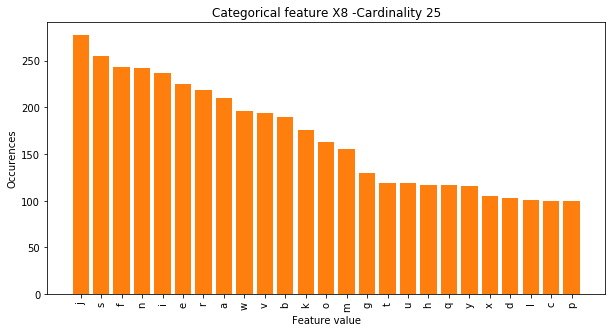

In [17]:
for c in counts[2]:
    value_counts =train[c].value_counts()
    fig,ax = plt.subplots(figsize=(10,5))
    plt.title('Categorical feature {} -Cardinality {}'.format(c, len(np.unique(train[c]))))
    plt.xlabel('Feature value')
    plt.ylabel('Occurences')
    plt.bar(range(len(value_counts)), value_counts.values, color=pal[1])
    
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='vertical')
    plt.show()

# XGBoost Starter

data가 어떻게 만들어졌는지에 대한 아웃라인을 알게됐다.
우리는 xgboost를 이용해서 심플한 모델을 만들것이다.

In [28]:
test =pd.read_csv('./test.csv')

# ID와 y(target)을 제외한 나머지 컬럼..
usable_columns=list(set(train.columns)-set(['ID','y']))

y_train= train['y'].values
id_test = test['ID'].values

x_train=train[usable_columns]
x_test =test[usable_columns]

for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality==1:
        #column with only 1 value is useless so we drop it
        x_train.drop(column, axis=1,inplace=True) 
        x_test.drop(column, axis=1, inplace=True)
        
    if cardinality>2:# column is cateorical
        mapper= lambda x: sum([ord(digit) for digit in x])
        
        x_train[column]=x_train[column].apply(mapper)
        x_test[column]=x_test[column].apply(mapper)
        
x_train.head()

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,X367,X259,X353,X350,X28,X116,X265,X158,X234,X287,...,X24,X295,X115,X363,X128,X200,X76,X240,X73,X163
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,1,1,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,1
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
4,0,0,0,1,1,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,0


In [30]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
                                                      test_size=0.2, random_state=4242)

d_train=xgb.DMatrix(x_train, label=y_train)
d_valid=xgb.DMatrix(x_valid, label=y_valid)
d_test =xgb.DMatrix(x_test)

params={}
params['objective']='reg:linear'
params['eta']=0.02
params['max_depth']=4

def xgb_r2_score(preds, dtrain):
    labels=dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist=[(d_train, 'train'), (d_valid, 'valid')]

clf=xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50,
             feval=xgb_r2_score, maximize=True, verbose_eval=10)

[10:03:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:98.9648	valid-rmse:99.8448	train-r2:-57.35	valid-r2:-62.902
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.0486	valid-rmse:81.809	train-r2:-38.1354	valid-r2:-41.9008
[20]	train-rmse:66.4386	valid-rmse:67.0989	train-r2:-25.2978	valid-r2:-27.8598
[30]	train-rmse:54.5384	valid-rmse:55.112	train-r2:-16.7208	valid-r2:-18.4695
[40]	train-rmse:44.8617	valid-rmse:45.3603	train-r2:-10.9903	valid-r2:-12.1891
[50]	train-rmse:37.0126	valid-rmse:37.4477	train-r2:-7.16165	valid-r2:-7.98905
[60]	train-rmse:30.6675	valid-rmse:31.0494	train-r2:-4.60318	valid-r2:-5.17973
[70]	train-rmse:25.5632	valid-rmse:25.895	train-r2:-2.89321	valid-r2:-3.2983
[80]	train-rmse:21.4835	valid-rmse:21.7738	train-r2:-1.74973	valid-r2:-

In [31]:
p_test=clf.predict(d_test)

sub=pd.DataFrame()
sub['ID']=id_test
sub['y']=p_test
sub.to_csv('xgb.csv', index=False)

In [32]:
sub.head()

,ID,y
0,1,100.292099
1,2,115.907982
2,3,97.479614
3,4,78.646759
4,5,111.727699
